In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
results2_dir          = config.get_property('results2_dir')

COLOR_LIST1 = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [2]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

patient_df       = pd.read_csv(os.path.join(feb_hosp_records_path, "patient_data_Feb_26_2023.csv"), parse_dates=['date'])
duplicated_tests = (patient_df[['mrn','date', 'procedure_description','organism_name']].duplicated() & patient_df['test']==1)
patient_df       = patient_df[~duplicated_tests]

duplicated_pos_tests                                 = (patient_df[['mrn', 'visit_id', 'organism_name']].duplicated() & ~patient_df['organism_name'].isnull())
patient_df.loc[duplicated_pos_tests,'test']          = 0
patient_df.loc[duplicated_pos_tests,'organism_name'] = np.nan

movement_df       = patient_df.copy()
duplicated_tests  = (movement_df[['mrn','date','procedure_description','organism_name']].duplicated() & movement_df['test']==1)
movement_df       = movement_df[~duplicated_tests]

duplicated_pos_tests = (movement_df[['mrn','visit_id','organism_name']].duplicated() & ~movement_df['organism_name'].isnull())
movement_df.loc[duplicated_pos_tests,'test'] = 0
movement_df.loc[duplicated_pos_tests,'organism_name'] = np.nan

movement_df["ward_total"] = movement_df.apply(lambda x: x.ward+"-"+x.building+"-"+x.place, axis=1)

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/1610801969.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:
sys.path.insert(0, "../pompjax/pompjax/")

from pyro.contrib.forecast import eval_crps
from eval import calibration

def compute_evals(samples, obs, beta, rho,  name_var="beta"):
    """_summary_

    Args:
        samples (_type_): num_ensembles x num_times
        obs (_type_): time series observation

    Returns:
        _type_: _description_
    """

    cal_df = calibration.calibration(np.expand_dims(samples.T, 0), np.expand_dims(obs, 0), observation_index=0)
    sc     = np.mean(np.abs(cal_df.quantiles.values-cal_df.proportion_inside.values))

    df_response                      = pd.DataFrame(columns=['crps', 'calibration_score', name_var, "rho"])
    df_response['crps']              = [eval_crps(samples, obs)]
    df_response["calibration_score"] = sc
    df_response[name_var]            = [beta]
    df_response['rho']               = [rho]
    return df_response


/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def create_amro_obs(amro, model_settings, resample="W-Sun"):
    dates_resamp = pd.date_range(model_settings["dates"][0], model_settings["dates"][-1], freq=resample)

    test_df         = movement_df.copy(); test_df = test_df[test_df["test"]==1]
    amro_df         = test_df.copy()
    amro_df["keep"] = amro_df["organism_name"].apply(lambda x: amro in str(x))
    amro_df         = amro_df[amro_df["keep"]==True]
    amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()
    amro_df         = amro_df.xs("test", axis=1, drop_level=True)
    amro_df         = amro_df.sum(axis=1)
    amro_df         = amro_df.reindex(dates_resamp, fill_value=0)

    return amro_df

In [6]:
from tqdm import tqdm
import torch

def generate_combination(arr1, arr2):
    a = []
    for a1 in arr1:
        for a2 in arr2:
            a.append([a1, a2])
    return np.array(a)

from models import amr_abm, observe_cluster

def simulate_abm(f, f0, g, beta, rho, model_settings):
    dates_simulation = model_settings["dates_simulation"]

    θ = np.array([[rho], [beta]]) * np.ones((model_settings["p"], model_settings["m"]))
    x = f0(θ)

    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def grid_search(f, f0, g, obs_df, model_settings, previous_search=None):
    βmin  = 0.0
    βmax  = 0.1
    βstep = 0.005

    ρmin  = 0.01
    ρmax  = 0.2
    ρstep = 0.01

    ρ_search     = np.arange(ρmin, ρmax, ρstep)
    β_search     = np.arange(βmin, βmax + βstep, βstep)

    p_new_df  = pd.DataFrame(generate_combination(ρ_search, β_search), columns=["rho", "beta"])
    if previous_search is not None:
        p_done_df = previous_search[["rho", "beta"]]
        p_df      = pd.concat([p_new_df, p_done_df]).drop_duplicates(subset=["rho", "beta"], keep=False)
    else:
        p_df      = p_new_df.copy()
    # sum across clusters
    obs_world  = obs_df.values

    metric_df = pd.DataFrame()
    for idx_row, row in tqdm(p_df.iterrows(), total=len(p_df)):
        rho, beta = row["rho"], row["beta"]

        observations       = simulate_abm(f, f0, g, beta, rho, model_settings)
        observations       = np.sum(observations, axis=1)
        sim_df             = pd.DataFrame(columns=["date","ens_id", "values", "scenario"])
        sim_df["values"]   = observations.flatten()
        sim_df["date"]     = flatten_list([ [date]*model_settings["m"]  for date in  list(model_settings["dates"])])
        sim_df["ens_id"]   = list(range(model_settings["m"] )) * len(model_settings["dates"])
        sim_df["rho"]      = rho

        samples_t  = sim_df.set_index(["date", "ens_id", "rho"]).unstack([1, 2]).resample("W-Sun").sum(numeric_only=True).stack().stack().reset_index()
        samples_t  = pd.pivot(data=samples_t, index="date", columns="ens_id", values="values").to_numpy().T
        samples_t  = torch.tensor(samples_t);  obs_t  = torch.tensor(list(obs_world))
        df_metrics = compute_evals(samples_t, obs_t, beta, rho)
        metric_df  = pd.concat([metric_df, df_metrics])

    return  pd.concat([metric_df, previous_search])

def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gamma        = amro_prev_df[amro_prev_df.amro==amro]["prevalence_mean1"].values[0]/100
    return gamma


In [7]:
model_settings                     = {}
model_settings["m"]                = 50
model_settings["p"]                = 2
model_settings["n"]                = movement_df.mrn_id.unique().shape[0]
model_settings["k"]                = movement_df.cluster.unique().shape[0]
model_settings["dates"]            = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")
model_settings["dates_simulation"] = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

amro_search = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS', 'STAPHYLOCOCCUS EPIDERMIDIS', 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']


In [9]:
from utils_local.misc import amro2cute, amro2title

for amro in amro_search:
    print("Running grid search for ", amro2title(amro))

    previous_search_df  = pd.read_csv( os.path.join("..", "preliminary_results", f"crps_{amro2cute(amro)}.csv"), index_col=None).drop(columns=['Unnamed: 0'])
    gamma               = empirical_prevalence(amro) * np.ones(model_settings["m"])
    alpha               = 1/120
    init_state          = lambda θ:       amr_abm(t = 0,
                                                    agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                    gamma          = gamma,
                                                    beta           = θ[1, :],
                                                    alpha          = alpha,
                                                    movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                    ward2size      = ward2size,
                                                    model_settings = model_settings)

    process_model       = lambda t, x, θ: amr_abm(t = t,
                                                    agents_state   = x,
                                                    gamma          = gamma,
                                                    beta           = θ[1, :],
                                                    alpha          = alpha,
                                                    movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                    ward2size      = ward2size,
                                                    model_settings = model_settings)

    observational_model = lambda t, x, θ: observe_cluster(t   = t,
                                                            agents_state    = x,
                                                            rho             = θ[0, :],
                                                            movement        = movement_df[movement_df["date"]==dates_simulation[t]],
                                                            model_settings  = model_settings)
    obs_df          = create_amro_obs(amro, model_settings, resample="W-Sun")

    # init state space
    search_amro_df = grid_search(process_model, init_state, observational_model,
                            obs_df, model_settings, previous_search=previous_search_df)

    os.makedirs(os.path.join(results2_dir, "grid_search", "abm"), exist_ok=True)
    search_amro_df.to_csv( os.path.join(results2_dir, "grid_search", "abm", f"{amro2cute(amro)}.csv"))



/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  E. coli


100%|██████████| 275/275 [21:28:54<00:00, 281.22s/it]     
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  K. pneumoniae


100%|██████████| 275/275 [6:39:06<00:00, 87.08s/it]  
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  P. aeruginosa


100%|██████████| 275/275 [6:38:34<00:00, 86.96s/it]  
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  MSSA


100%|██████████| 275/275 [6:39:42<00:00, 87.21s/it]  
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  MRSA


100%|██████████| 275/275 [6:52:26<00:00, 89.99s/it]  
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  S. epidermidis


100%|██████████| 275/275 [7:02:19<00:00, 92.14s/it]  
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  E. faecalis


100%|██████████| 275/275 [7:15:55<00:00, 95.11s/it]  
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_9072/3994308721.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df         = amro_df.groupby(["date", "cluster"]).sum()[["test"]].unstack([1]).fillna(0).resample("W-Sun").sum()


Running grid search for  E. faecium


100%|██████████| 275/275 [8:17:04<00:00, 108.45s/it]  


In [15]:

amro         = amro_search[0]
grid_amro_df = pd.read_csv( os.path.join(results2_dir, "grid_search", "abm", f"{amro2cute(amro)}.csv") ).drop(columns=["Unnamed: 0"]).reset_index(drop=True)


,crps,calibration_score,beta,rho
0,46.061074,0.612500,0.000,0.01
1,45.742695,0.612500,0.005,0.01
2,45.471516,0.612500,0.010,0.01
3,45.126716,0.612500,0.015,0.01
4,44.847818,0.612500,0.020,0.01
...,...,...,...,...
398,34.829647,0.581798,0.020,0.20
399,41.974375,0.586184,0.025,0.20
400,48.587786,0.577412,0.030,0.20
401,55.032581,0.577412,0.035,0.20


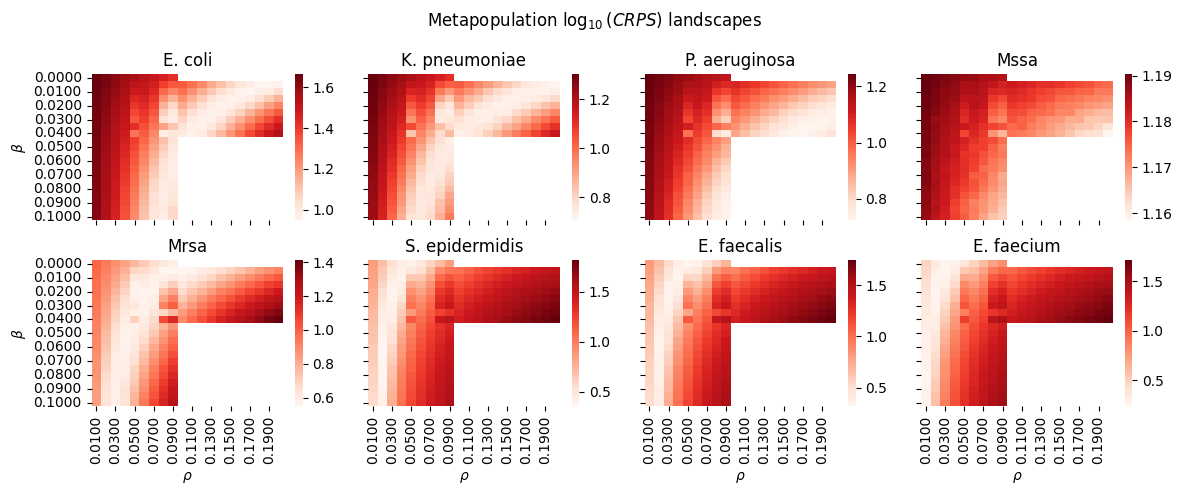

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

amro_search = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS', 'STAPHYLOCOCCUS EPIDERMIDIS', 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

fig, ax = plt.subplots(2, 4, figsize=(12, 5), sharey=True, sharex=True)

for idx_axi, axi in enumerate(ax.flatten()):
    amro                     = amro_search[idx_axi]
    grid_amro_df             = pd.read_csv( os.path.join(results2_dir, "grid_search", "abm", f"{amro2cute(amro)}.csv") ).reset_index(drop=True)
    grid_amro_df             = grid_amro_df.drop_duplicates(subset=["beta", "rho"]).drop(columns=["Unnamed: 0"])

    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.4f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.4f}")
    grid_amro_df             = grid_amro_df.drop_duplicates(subset=["beta_str", "rho_str"])

    hm_crps_df               = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='crps')

    sns.heatmap(ax=axi, data=np.log10(hm_crps_df), cmap='Reds')
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.set_title(". ".join(amro2cute(amro).split("_")).capitalize())

ax[0, 0].set_ylabel(r'$\beta$')
ax[1, 0].set_ylabel(r'$\beta$')

for i in range(4):
    ax[1, i].set_xlabel(r'$\rho$')

fig.suptitle(r"Metapopulation $\log_{{10}}(CRPS)$ landscapes")
plt.tight_layout()


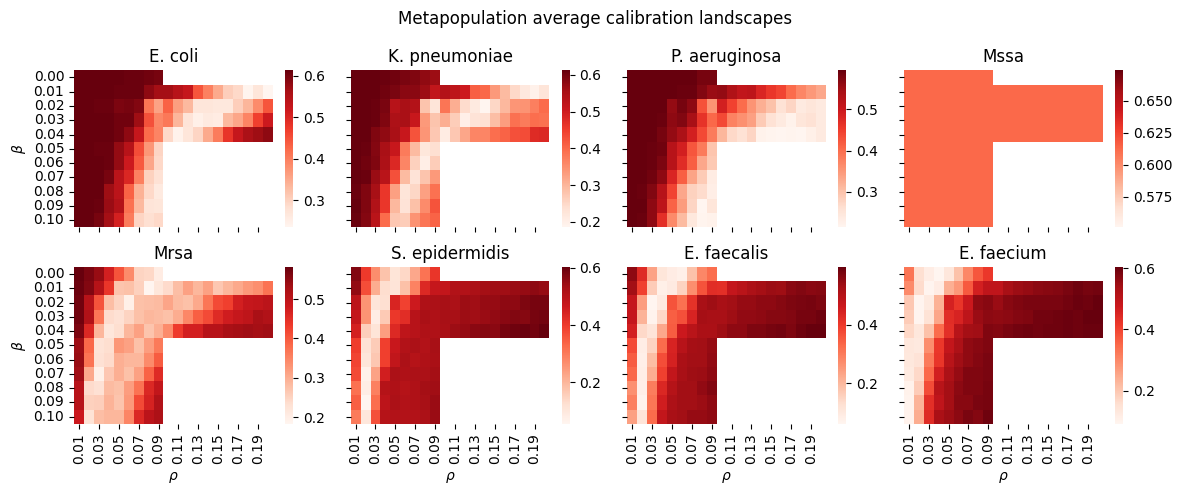

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(12, 5), sharey=True, sharex=True)

for idx_axi, axi in enumerate(ax.flatten()):
    amro         = amro_search[idx_axi]

    grid_amro_df = pd.read_csv( os.path.join(results2_dir, "grid_search", "abm", f"{amro2cute(amro)}.csv") ).reset_index(drop=True)
    grid_amro_df = grid_amro_df.drop_duplicates(subset=["beta", "rho"]).drop(columns=["Unnamed: 0"])
    grid_amro_df = grid_amro_df[grid_amro_df.rho<0.3]

    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.2f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.2f}")
    grid_amro_df             = grid_amro_df.drop_duplicates(subset=["beta_str", "rho_str"], keep="first")

    hm_cov_df    = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='calibration_score')

    sns.heatmap(ax=axi, data=hm_cov_df, cmap='Reds')
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.set_title(". ".join(amro2cute(amro).split("_")).capitalize())

ax[0, 0].set_ylabel(r'$\beta$')
ax[1, 0].set_ylabel(r'$\beta$')

for i in range(4):
    ax[1, i].set_xlabel(r'$\rho$')

fig.suptitle("Metapopulation average calibration landscapes")
plt.tight_layout()